In [1]:
import torch
from torchvision import datasets, transforms,models
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torchvision
import os
import json
import random
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt    
import matplotlib.image as mpimg
import time

In [2]:
import zipfile
with zipfile.ZipFile('TestDataSet.zip','r') as zip_ref:
    zip_ref.extractall("TestDataSet")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    

dict_keys(['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship', '406: altar', '407: ambulance', '408: amphibian', '409: analog clock', '410: apiary', '411: apron', '412: ashcan', '413: assault rifle', '414: backpack', '415: bakery', '416: balance beam', '417: balloon', '418: ballpoint', '419: Band Aid', '420: banjo', '421: bannister', '422: barbell', '423: barber chair', '424: barbershop', '425: barn', '426: barometer', '427: barrel', '428: barrow', '429: baseball', '430: basketball', '431: bassinet', '432: bassoon', '433: bathing cap', '434: bath towel', '435: bathtub', '436: beach wagon', '437: beacon', '438: beaker', '439: bearskin', '440: beer bottle', '441: beer glass', '442: bell cote', '443: bib', '444: bicycle-built-for-two', '445: bikini', '446: binder', '447: binoculars', '448: birdhouse', '449: boathouse', '450: bobsled', '451: bolo tie', '452: bonnet', '453: bookcase', '454: bookshop', '455: bottlecap', '456: bow', '457: bow ti

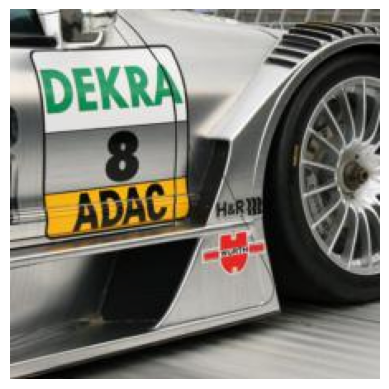

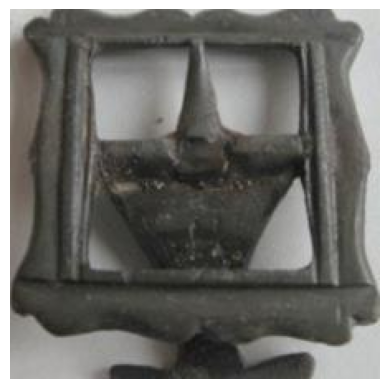

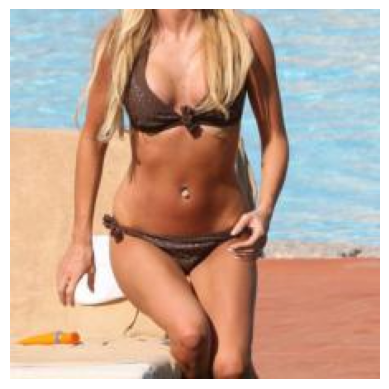

In [3]:
pretrained_model = models.resnet34(weights='IMAGENET1K_V1')
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean=mean_norms,
std=std_norms)
])
dataset_path = "./TestDataSet/TestDataSet"

with open('./TestDataSet/TestDataSet/labels_list.json') as f:
    class_map = json.load(f)

New_map={m:k for k, m in enumerate(class_map)}


print(New_map.keys())
print(New_map.values())
print(list(New_map.keys())[0])
    
Train_times = [] 

dataset = datasets.ImageFolder(root=dataset_path,transform=plain_transforms)
print(dataset.class_to_idx)

dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
# loss=torch.nn.CrossEntropyLoss()
# optim=torch.optim.AdamW(pretrained_model.parameters(), lr=1e-3, weight_decay=1e-2)

offset = 401

def evaluate_topk(model, dataloader, offset,device):
    model.eval()
    with torch.no_grad():
        top1_correct, top5_correct, total = 0, 0, 0
        for _, (images, labels) in enumerate(dataloader):
            x = images.to(device)
            y = labels.to(device) + offset 
            out = model(x)
            _, pred1 = out.max(dim=1)  
            top5_preds = out.topk(5, dim=1).indices
            top1_correct += (pred1 == y).sum().item()
            top5_correct += top5_preds.eq(y.unsqueeze(1)).any(dim=1).sum().item()
            total += labels.size(0)  
    top1 = top1_correct / total * 100
    top5 = top5_correct / total * 100
    print(f"Top-1 Accuracy: {top1:.2f}%")
    print(f"Top-5 Accuracy: {top5:.2f}%")
    
evaluate_topk(pretrained_model,dataloader,offset,device)

index = len(dataset)
select = random.sample(range(index), k=3)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
eli_list=[]

def un_normalzied(img, mean, std):
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]
    return img

import random
def visualize_images(dataloader, select,mean,std):
    dataset = dataloader.dataset
    print(select)
    for n in range(len(select)):
        index=select[n]
        image,_ = dataset[index]
        
        if isinstance(image, torch.Tensor):
            image = image.squeeze().cpu().numpy()
        else:
            image = np.array(image)
            
        image=un_normalzied(image,mean,std)
        image = np.transpose(image, (1, 2, 0))
        image = np.clip(image, 0, 1)
        plt.figure()
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        
def check_eli(perturbed,image,epsilon,r=1e-7):
    diff = torch.abs(perturbed - image)    
    max_per_image = diff.view(diff.size(0), -1).max(dim=1).values
    epsilon_loss=epsilon+r
    if(max_per_image > epsilon_loss).any():
        return False
    else:
        return True
    

torch.save(dataloader, 'dataloader.pt')        
visualize_images(dataloader,select,mean,std)

ε is perfect
Adversarial_Test_Set_1
Top-1 Accuracy: 6.20%
Top-5 Accuracy: 35.60%
[390, 315, 220]


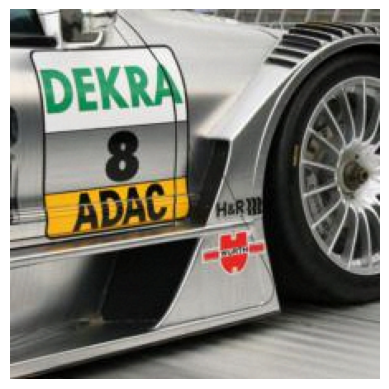

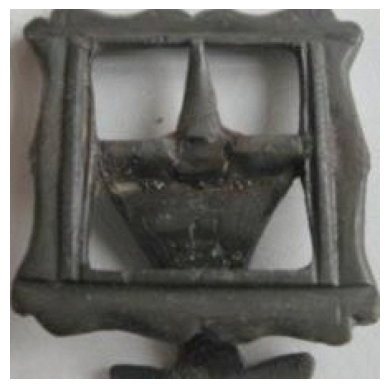

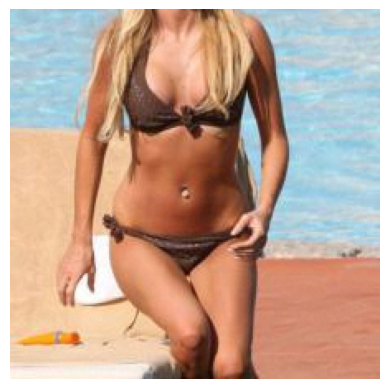

In [4]:
def fgsm_attack(x, epsilon, grad):
    return x + epsilon * grad.sign()

    
def make_fgsm(model, dataloader, epsilon, offset, device):
    model.eval()
    Is_False=False
    images, labels = [], []
    start_time = time.perf_counter()
    L = nn.CrossEntropyLoss()
    for image, label in dataloader:
        image = image.to(device).requires_grad_(True)
        true_idxs = label.to(device) + offset
        outputs = model(image)
        loss = L(outputs, true_idxs)
        loss.backward()

        perturbed = fgsm_attack(image, epsilon, image.grad)
        perturbed = torch.max(torch.min(perturbed, image + epsilon),image - epsilon)
        
        Error=check_eli(perturbed,image,epsilon)
        if Error==False:
            Is_False=True
            
        images.append(perturbed.detach().cpu())
        labels.append(label)
        
    if Is_False==False:
        print("ε is perfect")
    else:
        print("ε has error")
    
    end_time = time.perf_counter()
    total_time = end_time - start_time
    Train_times.append(total_time)
    eli_list.append(epsilon)
    dataset = TensorDataset(torch.cat(images), torch.cat(labels))
    return dataset

epsilon = 0.02

Attack = make_fgsm(pretrained_model, dataloader, epsilon, offset, device)
Adversarial_Test_Set_1 = DataLoader(Attack, batch_size=32, shuffle=False)

print("Adversarial_Test_Set_1")
evaluate_topk(pretrained_model, Adversarial_Test_Set_1, offset, device)
visualize_images(Adversarial_Test_Set_1,select,mean,std)
torch.save(Adversarial_Test_Set_1, 'Adversarial_Test_Set_1.pt')


ε is perfect
Adversarial_Test_Set_2
Top-1 Accuracy: 0.00%
Top-5 Accuracy: 15.40%
[390, 315, 220]


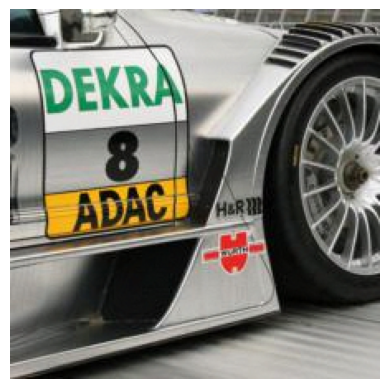

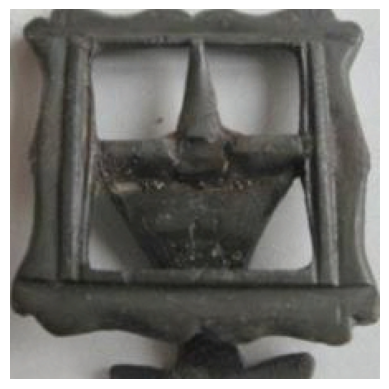

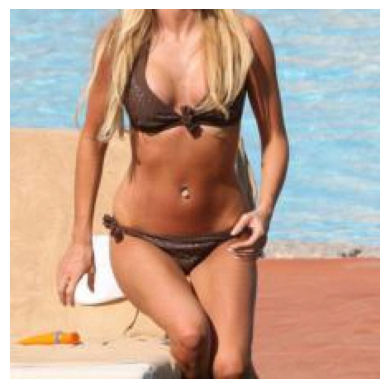

In [5]:
def pgd_attack(x, y, model, epsilon, iters):
    delta = torch.zeros_like(x).uniform_(-epsilon/4, epsilon/4).to(x.device)  
    delta.requires_grad_(True)
    L = nn.CrossEntropyLoss()

    for _ in range(iters):
        outputs = model(x + delta)
        loss = L(outputs, y)
        loss.backward()
        delta.data = (delta + epsilon * delta.grad.sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()

    return (x + delta).detach()

def make_pgd(model, dataloader, epsilon, iters, offset, device):
    model.eval()
    start_time = time.perf_counter()
    Is_False=False
    images, labels = [], []
    for image, label in dataloader:
        image = image.to(device)
        true_idxs = label.to(device) + offset
        perturbed = pgd_attack(image, true_idxs, model, epsilon, iters)
        perturbed = torch.max(torch.min(perturbed, image + epsilon),image - epsilon)
        
        Error=check_eli(perturbed,image,epsilon)
        if Error==False:
            Is_False=True
            
        images.append(perturbed.cpu())
        labels.append(label)
    end_time = time.perf_counter()
    total_time = end_time - start_time
    Train_times.append(total_time)
    eli_list.append(epsilon)    
    if Is_False==False:
        print("ε is perfect")
    else:
        print("ε has error")

    return TensorDataset(torch.cat(images), torch.cat(labels))

epsilon, iters = 0.02, 100
Attack2 = make_pgd(pretrained_model, dataloader, epsilon, iters, offset, device)
Adversarial_Test_Set_2 = DataLoader(Attack2, batch_size=32, shuffle=False)

print("Adversarial_Test_Set_2")
evaluate_topk(pretrained_model, Adversarial_Test_Set_2, offset, device)
visualize_images(Adversarial_Test_Set_2,select,mean,std)
torch.save(Adversarial_Test_Set_2, 'Adversarial_Test_Set_2.pt')

ε is perfect
Adversarial_Test_Set_3
Top-1 Accuracy: 13.80%
Top-5 Accuracy: 58.80%
[390, 315, 220]


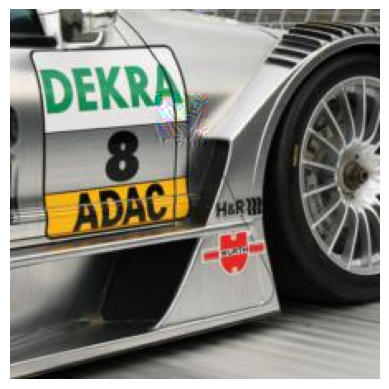

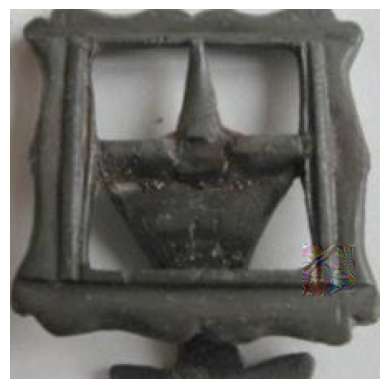

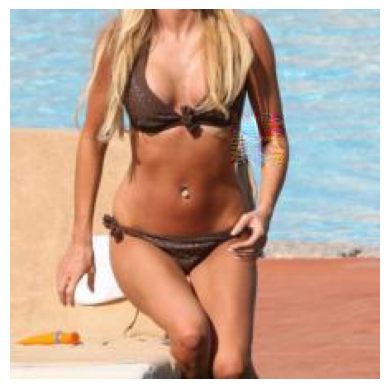

In [6]:
def patch_attack(x, y, model, epsilon, patch_size, iters,S=0.1):
    L = nn.CrossEntropyLoss()
    delta = torch.zeros_like(x)
    B, C, H, W = x.shape
    i = torch.randint(0, H - patch_size + 1, (1,)).item()
    j = torch.randint(0, W - patch_size + 1, (1,)).item()
    delta[:, :, i:i+patch_size, j:j+patch_size] = torch.zeros((B, C, patch_size, patch_size), device=x.device).uniform_(-epsilon/4, epsilon/4)
    delta.requires_grad_(True)
    
    for _ in range(iters):
        outputs = model(x + delta)
        loss = L(outputs, y)
        loss.backward()
        delta.data[:, :, i:i+patch_size, j:j+patch_size] = (
            delta[:, :, i:i+patch_size, j:j+patch_size] +
            S*epsilon * delta.grad.sign()[:, :, i:i+patch_size, j:j+patch_size]
        ).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    
    return (x + delta).detach()

def make_patch(model, dataloader, epsilon, patch_size, iters, offset, device):
    model.eval()
    start_time = time.perf_counter()
    Is_False=False
    images, labels = [], []
    for image, label in dataloader:
        image = image.to(device)
        true_idxs = label.to(device) + offset
        perturbed = patch_attack(image, true_idxs, model, epsilon, patch_size, iters)
        perturbed = torch.max(torch.min(perturbed, image + epsilon),image - epsilon)
               
        Error=check_eli(perturbed,image,epsilon)
        if Error==False:
            Is_False=True
        
        images.append(perturbed.cpu())
        labels.append(label)
    end_time = time.perf_counter()
    total_time = end_time - start_time
    Train_times.append(total_time)
    eli_list.append(epsilon)    
    if Is_False==False:
        print("ε is perfect")
    else:
        print("ε has error")
    
    return TensorDataset(torch.cat(images), torch.cat(labels))

epsilon, patch_size, iters = 0.5, 32, 100
Attack3 = make_patch(pretrained_model, dataloader, epsilon,patch_size,iters, offset, device)
Adversarial_Test_Set_3 = DataLoader(Attack3, batch_size=32, shuffle=False)

print("Adversarial_Test_Set_3")
evaluate_topk(pretrained_model, Adversarial_Test_Set_3, offset, device)
visualize_images(Adversarial_Test_Set_3,select,mean,std)
torch.save(Adversarial_Test_Set_3, 'Adversarial_Test_Set_3.pt')

In [9]:
transfer_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1).to(device)

List_name=["Original","FGSM","PGD","Patch"]
List_data=["dataloader","Adversarial_Test_Set_1","Adversarial_Test_Set_2","Adversarial_Test_Set_3"]

for i in range(4):
    dataset = torch.load(f"{List_data[i]}.pt")
    print(f"\n{List_name[i]} on resnet34")
    evaluate_topk(pretrained_model, dataset, offset, device)
    print(f"\n{List_name[i]} on densenet121")
    evaluate_topk(transfer_model, dataset, offset, device)

for i in range(3):
    print(f"\nTraining adversarial test set time")
    print(f"{List_data[i]} with {eli_list[i]} need {Train_times[i]}")

C:\Users\26435\AppData\Local\Temp\ipykernel_24428\253634248.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(f"{List_data[i]}.pt")



Original on resnet34
Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%

Original on densenet121
Top-1 Accuracy: 74.60%
Top-5 Accuracy: 93.60%

FGSM on resnet34
Top-1 Accuracy: 6.20%
Top-5 Accuracy: 35.60%

FGSM on densenet121
Top-1 Accuracy: 63.40%
Top-5 Accuracy: 88.80%

PGD on resnet34
Top-1 Accuracy: 0.00%
Top-5 Accuracy: 15.60%

PGD on densenet121
Top-1 Accuracy: 66.40%
Top-5 Accuracy: 90.20%

Patch on resnet34
Top-1 Accuracy: 13.80%
Top-5 Accuracy: 58.80%

Patch on densenet121
Top-1 Accuracy: 70.40%
Top-5 Accuracy: 92.60%

Training adversarial test set time
dataloader with 0.02 need 2.0976329000004625

Training adversarial test set time
Adversarial_Test_Set_1 with 0.02 need 120.64770109999881

Training adversarial test set time
Adversarial_Test_Set_2 with 0.5 need 120.98583710000094
